In [1]:
import numpy as np
from scipy import signal
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

In [2]:
import os
os.chdir('Jupyter/SiPM/')

In [3]:
import matplotlib.pyplot as plt
plt.style.use('../../style.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
import sys
sys.path.insert(0, '../../../purity-monitor/')
sys.path.insert(0, '../../WaveformAnalysis/')

In [5]:
import Dataset as Dataset
import StandMonitor as Monitor
import PlotFunctions as Plt
import Waveform as Waveform
import SiPM as SiPM

In [6]:
import importlib
importlib.reload(Dataset)
importlib.reload(Monitor)
importlib.reload(Plt)
importlib.reload(SiPM)

<module 'SiPM' from '../../../purity-monitor/SiPM.py'>

In [7]:
D0 = SiPM.SiPM(Path='/project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211119/', 
                    Selection='*DCR*.h5')
D0.Ch = [Waveform.Waveform(ID=x, Pol=1) for x in range(1,3)]

print(len(D0.Files))
for i,File in enumerate(D0.Files):
    print(i)
    print('Getting data...')
    D0.ImportDataFromHDF5(File, D0.Ch)

    print('Getting sampling information...')
    D0.get_sampling()

    print('Getting filtered waveforms...')
    D0.Ch[0].Amp = D0.run_filter(D0.Ch[0].Amp)

    print('Getting deconvolved waveforms...')
    D0.Ch[0].Deconv = D0.run_deconvolution(D0.Ch[0].Amp)

    print('Getting peak amplitudes and positions...')
    D0.get_peaks(D0.Ch[0].Deconv)

    print('Clearing variables...')
    D0.clear()

226
0
Getting data...
Getting sampling information...
Getting filtered waveforms...
Getting deconvolved waveforms...
Getting deconvolution filter...
Getting peak amplitudes and positions...
Clearing variables...
1
Getting data...
Getting sampling information...
Getting filtered waveforms...
Getting deconvolved waveforms...
Getting peak amplitudes and positions...
Clearing variables...
2
Getting data...
Getting sampling information...
Getting filtered waveforms...
Getting deconvolved waveforms...
Getting peak amplitudes and positions...
Clearing variables...
3
Getting data...
Getting sampling information...
Getting filtered waveforms...
Getting deconvolved waveforms...
Getting peak amplitudes and positions...
Clearing variables...
4
Getting data...
Getting sampling information...
Getting filtered waveforms...
Getting deconvolved waveforms...
Getting peak amplitudes and positions...
Clearing variables...
5
Getting data...
Getting sampling information...
Getting filtered waveforms...
Gett

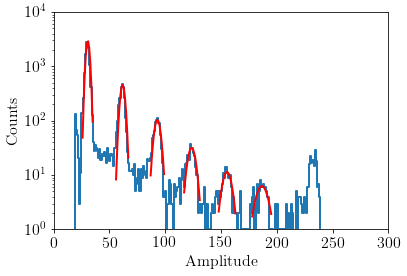

In [9]:
def gauss_func(x,a,b,c):
    return a*np.exp(-(x-b)**2/(2*c**2))

h,hx = np.histogram(D0.peak_height, bins=np.arange(0,300,1))

pe = np.median(D0.peak_height)
pe_fit = []

plt.figure()
for i in range(1,7):
    cut = np.where((hx[:-1]>pe*i-5-1.5*i) & (hx[:-1]<pe*i+4))
    
    popt,pcov = curve_fit(gauss_func, hx[:-1][cut], h[cut], 
                          p0=[np.max(h[cut]), pe*i,10])
    pe_fit.append(popt)
    plt.plot(hx[:-1][cut], gauss_func(hx[:-1][cut], *popt), color='r', zorder=10)

pe_fit = np.array(pe_fit)    

plt.xlabel('Amplitude')
plt.ylabel('Counts')
plt.yscale('log')
plt.step(hx[:-1], h, lw=2)
plt.savefig('deconvolution_hist_pe.pdf')
plt.show()

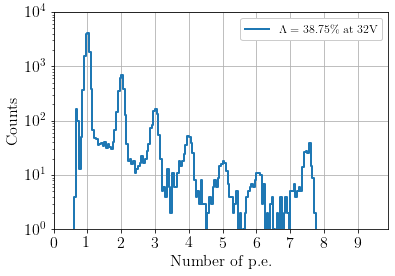

In [10]:
gain = np.diff(pe_fit[:,1])
gain = np.insert(gain,0,pe_fit[0,1])
D0.peak_height_calib = np.array(D0.peak_height)/np.mean(gain)
ca = (np.mean(D0.peak_height_calib[D0.peak_height_calib<7]) - 1)*100

h,hx = np.histogram(D0.peak_height_calib, bins=np.arange(0,10,0.05))

plt.figure()
plt.grid()
plt.xticks(np.arange(0,10,1))
plt.xlabel('Number of p.e.')
plt.ylabel('Counts')
plt.yscale('log')
plt.step(hx[:-1], h, lw=2, where='post', label='$\Lambda={:.2f}$\% at 32V'.format(ca))
plt.legend(loc='upper right')
plt.savefig('deconvolution_hist_pe.pdf')
plt.show()

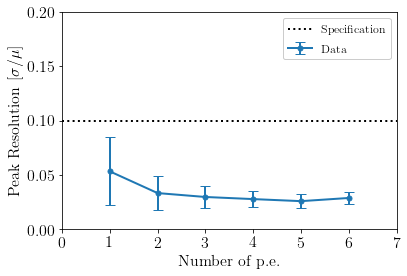

In [11]:
res = np.abs(pe_fit[:,2])/pe_fit[:,1]
fit_err = np.sqrt(np.diag(pcov))
res_err = np.sqrt(pe_fit[:,2]**2/pe_fit[:,1]**4 * fit_err[1]**2 + 1.0/pe_fit[:,1]**2 * fit_err[2]**2)

plt.figure()
plt.xticks(np.arange(0,len(res)+2,1))
plt.xlim(0,len(res)+1)
plt.ylim(0,0.2)
plt.xlabel('Number of p.e.')
plt.ylabel('Peak Resolution [$\sigma/\mu$]')
plt.errorbar(np.arange(1,len(res)+1,1), res, yerr=res_err, marker='o', ms=5, label='Data')
plt.hlines(y=0.1, xmin=0, xmax=len(res)+1, ls=':', label='Specification')
plt.legend(loc='upper right')
plt.show()